# Project: Predicting Boston Housing Prices
## Model Evaluation & Validation (Machine Learning Nanodegree, Udacity)

## Introduction
In this project, we shall evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)

# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
We will make a cursory investigation about the Boston housing data and provide our observations. Familiarizing with the data through an explorative process is a fundamental practice to better understand and justify the predicted results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics

The code cells below implement the following : 
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
- Store each calculation in their respective variable.
- Calculate correlation and plot scatter plots.

In [2]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


In [3]:
# Calculate correlation and joint plot for the features
def calc_corr_and_plot(feature_name):    
    sns.jointplot(prices, features[feature_name], kind = 'reg');
    plt.title('Correlation statistics for the feature : ' + feature_name, y=1.22)
    plt.xticks(rotation=90)
    plt.xlim((0, None))
    plt.ylim((0, None))
    plt.show()

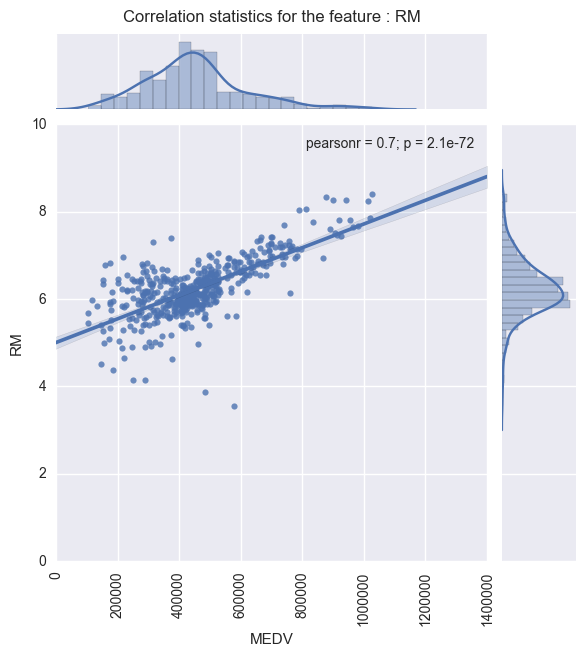

In [4]:
# Statistics for RM
calc_corr_and_plot('RM')

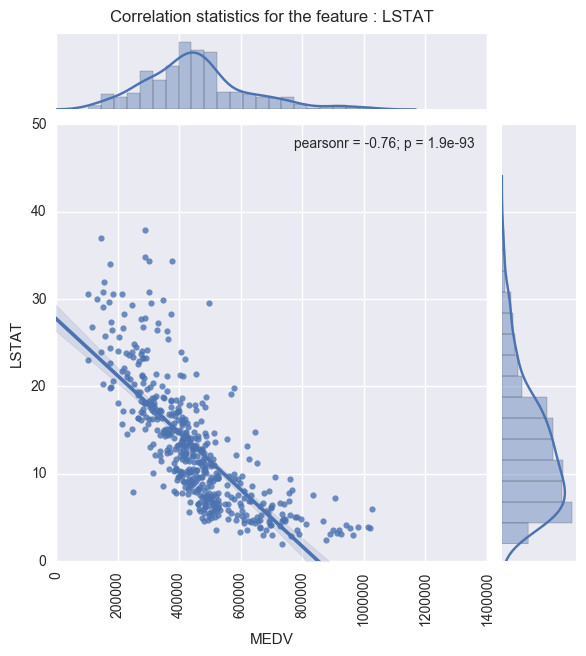

In [5]:
# Statistics for LSTAT
calc_corr_and_plot('LSTAT')

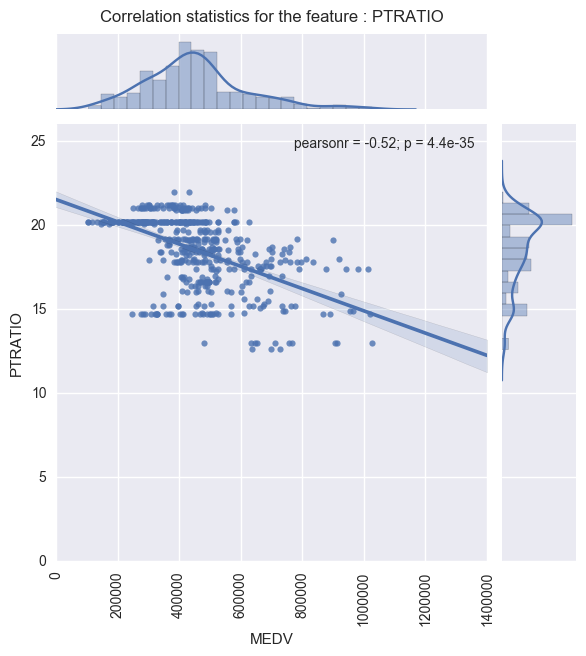

In [6]:
# Statistics for PTRATIO
calc_corr_and_plot('PTRATIO')

### Feature Observation

For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

**Analysis :**

**1. RM :** An increase in the value of this feature should lead to an **increase** in the value of 'MEDV' since a house having more rooms is more desirable to a prospective buyer than one which has less.

**2. LSTAT :** An increase in the value of this feature should lead to a **decrease** in the value of 'MEDV' since a community consisting of more numbers of "lower class" people will lead to a decrease in the value of properties in that community.

**3. PTRATIO:** An increase in the value of this feature should lead to a **decrease** in the value of 'MEDV' since a larger proportion of students isn't favorable to potential buyers. They will prefer having more teachers to teach their kids.

The correlation values have been calculated below to confirm this intuition :

In [7]:
data.corr()['MEDV']

RM         0.697209
LSTAT     -0.760670
PTRATIO   -0.519034
MEDV       1.000000
Name: MEDV, dtype: float64

----

## Developing a Model

In this second section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Implementation: Definition of a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, we shall implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [8]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Goodness of Fit

Assuming that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

We shall calculate this model's coefficient of determination using the code cell below : 

In [9]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
* R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. 
* R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

**Observation:** The given model can successfully capture the variation of the target variable. It has a R2 score of 0.923 which is very close to the upper limit of 1. Hence, 92.3% of the variance of the target variable can be predicted from the model.

### Implementation: Shuffle and Split Data
Next, we shall take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, we will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [10]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size = 0.2, random_state = 97)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Training and Testing

**Benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm :**

The benefit of splitting a dataset is that it allows us to measure which model is doing better. While the training points help the model to learn, the testing points help to determine how well these new points can be approximated by the model. Both underfitting and overfitting models will tend to do worse if there are more no. of testing points. On the other hand, a well fitted model will do well even if we increase the no. of testing points. The shape of this learning curve (using training and testing points) helps to determine whether the model is overfitting, underfitting or perfectly fitting.

----

## Analyzing Model Performance
In this third section of the project, we shall take a look at several models' learning and testing performances on various subsets of training data. Additionally, we shall investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

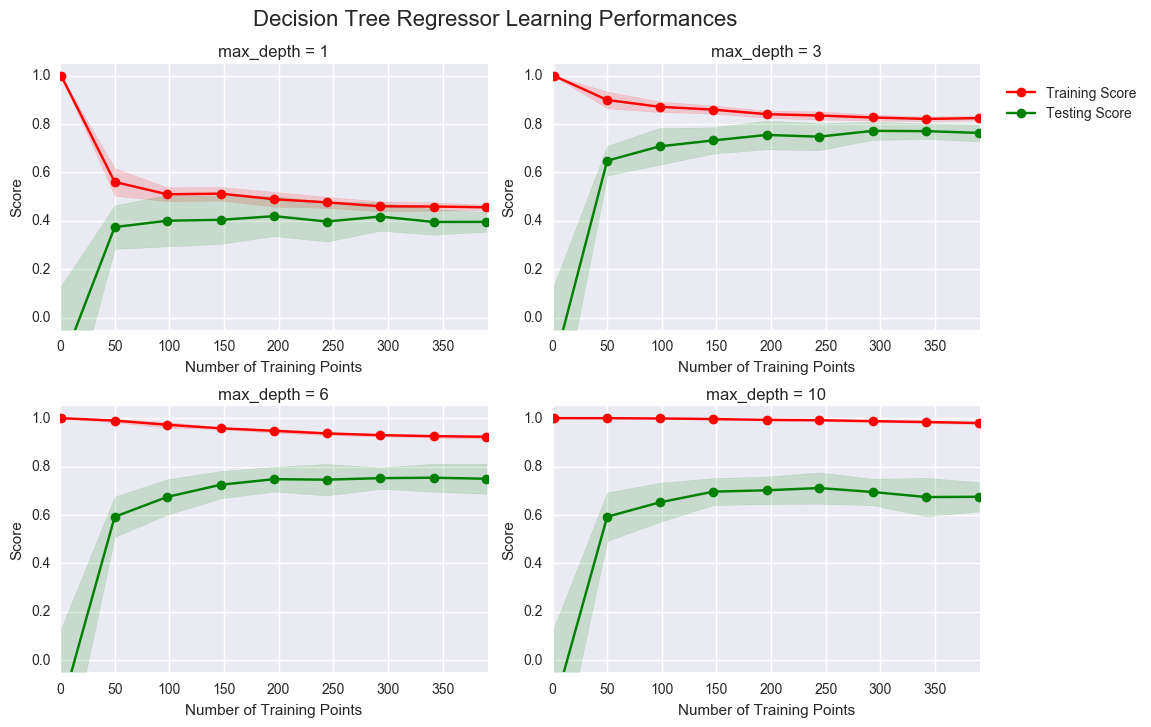

In [11]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data

Considering the performance graph of the model having **max depth of 3**, the following are the observations : 
- As more points are added, the score of the training curve decreases a little and then tends to stabilize around the 0.8 mark. For the testing curve, the score increases at first and then converges with the training curve around the 0.8 mark.
- Since the training and testing curves converge at a score of around 80%, having more training points (> 400) will not benefit the model. Neither the training score, nor the testing score will increase too much beyond the 400 points mark.
- Out of all the four graphs, this one (max depth = 3) is the best-fitting.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

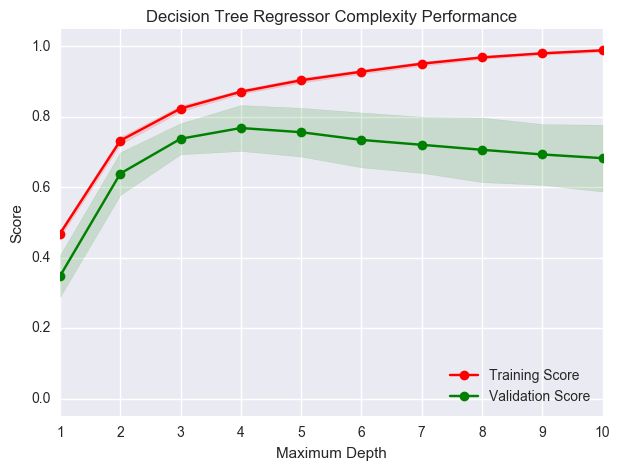

In [12]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff
- At max depth of 1, the model suffers from high bias. It is a case of underfitting. From the graph, it is clear that the validation score is pretty low (< 40%), thus indicating that it is not complex enough.
- At max depth of 10, the model suffers from high variance. It is a case of overfitting. From the graph, it is clear that the training score is significantly higher than the validation score, thus indicating that the model cannot generalize well.

### Best-Guess Optimal Model

- The maximum depth that best generalizes to unseen data is : 4
- The reason is that it gives us the best validation score while still not being over-complicated. Any further increase from a max depth of 4 results in decreasing cross validation scores.

-----

## Evaluating Model Performance
In this final section of the project, we shall construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search

The Grid Search technique is a way of finding the best model (i.e. the best combination of the hyper parameters of a learning algorithm) by making a grid and evaluating the performance of the model in each cell of this grid. The cell having the best score (say F1 score) is our best model. Each dimension of this grid corresponds to a hyper parameter. 

For example, in SVM, we have two hyper-parameters : kernel and C. We can put the different values of kernel (linear / polynomial) in different columns and in each row we can put different values of C. Using the grid search technique, we would then need to calculate the score for each combination of kernel and C, and subsequently, find the best among these combinations.

### Cross-Validation

**k-fold cross-validation training technique**

In the k-fold cross validation technique, we divide our data into 'k' buckets and train our model 'k' times. In each training iteration, we use a different bucket for testing, and the remaining data is used for training. The average performance score of all the 'k' iterations gives us the overall performance measure of the model.

**Benefit of this technique for grid search when optimizing a model**

The problem with grid search is that it requires another subset of data - called the validation set in addition to the testing set, to calcualte the score in each cell. When the no. of training data points is less, this can lead to a wastage of data points. In such cases, we can use k-fold cross validation to solve this problem. The advantage of k-fold cross validation is that the 'validation set' is no longer required : k-1 parts of the training data is used for training and the remaining 1 part is used for validation. Since this is repeated k times, we make use of all the training data for both training and validation while still not breaking the fundamental rule of not using testing data for training purposes.

### Implementation: Fitting a Model
Next, we shall bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, our implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique described previously, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*.

**Links :**
- [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)
- [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [13]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth' : range(1, 11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model

The code block below fits the decision tree regressor to the training data and produces an optimal model.

In [14]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


Hence, we can now conclusively say that the optimal model has a max depth of 4.

### Predicting Selling Prices
Now, we shall try to predict the house selling prices for the following clients : 

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

The code block below lets the optimized model make predictions for each client's home.

In [18]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $410,637.50
Predicted selling price for Client 2's home: $224,616.00
Predicted selling price for Client 3's home: $891,975.00


The recommended prices for Client 1, 2 and 3 would be : \$410,637.50, \$224,616.00 and \$891,975.00 respectively.

**Analysis of the predictions:**
These prices fall within the minimum and maximum prices present in the data-set. Also, the mean price is around 450k with a standard deviation of 165k, so these prices seem reasonable. Also, if we compare the three houses, the most favourable house (i.e. the one belonging to Client 3, having more rooms, lowest powerty and lowest student-teacher ratio) has been predicted to have the highest selling price. Similarly, the prices for clients 1 and 2 also seem reasonable.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**The code cell below runs the `fit_model` function 20 times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on. It also plots these points on a graph.**

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00
Trial 11: $406,933.33
Trial 12: $407,480.77
Trial 13: $410,146.15
Trial 14: $327,450.00
Trial 15: $408,240.00
Trial 16: $416,550.00
Trial 17: $413,917.24
Trial 18: $412,950.00
Trial 19: $423,913.64
Trial 20: $397,740.00

Range in prices: $97,485.00


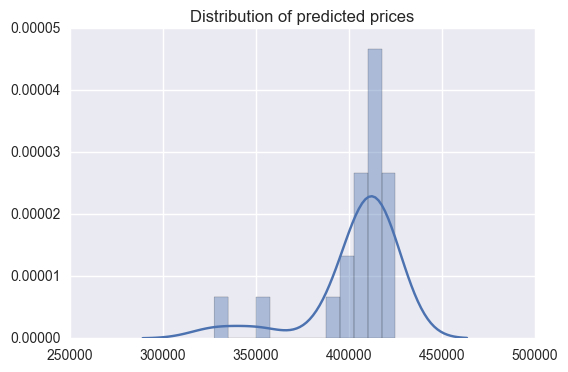

In [29]:
# Plot the prices

def plotTrials(X, y, fitter, input_data, n):
    """Plots the trials for n trials"""
    prices = []
    for k in range(n):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)

        # Fit the data
        reg = fitter(X_train, y_train)

        # Make a prediction
        pred = reg.predict([input_data[0]])[0]
        prices.append(pred)
        
        print "Trial {}: ${:,.2f}".format(k+1, pred)
    ax = sns.distplot(prices)
    plt.title('Distribution of predicted prices')
    # Display price range
    print "\nRange in prices: ${:,.2f}".format(max(prices) - min(prices))
    
plotTrials(features, prices, fit_model, client_data, 20)

### Applicability

The constructed model is perhaps a bit too simplistic to be used in a real-world setting that requires high accuracy.

The reasons are the following : 

1. The collected data is too old (1978). Features that are more important for real-estate in modern times might be significantly different than those in 1978. Moreover, it's difficult to accurately correct the prices for inflation and changing trends.
2. The no. of features used in the model might not be sufficient to fully predict the prices. There could be several other important features such as - plot area, maintenance of the house, transportation facilities, etc.
3. The range in prices for multiple predictions of the same client, seems to be too high (approx $70k). There needs to be more consistency.
4. The weightage of the factors that are important for predicting house prices would probably be different for rural cities & urban cities.
5. It's not always fair to judge the price of an individual home based on the characteristics of the entire neighbourhood. While the neighbourhood certainly plays a very important role, there could be some houses that really stand out and deserve a much higher or lower price.